In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Flatten,Dropout,BatchNormalization, UpSampling2D,add, Bidirectional
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import InceptionResNetV2
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical

import gensim.downloader as api
import os
from PIL import Image
from tqdm import tqdm
import string


In [2]:
caption_path = r'D:\tfolder\codingFile\AIlearning\projects\Image_captioning\captions.txt'
image_folder = r'D:\tfolder\codingFile\AIlearning\projects\Image_captioning\Images'

## Getting image features

In [3]:
image_model = InceptionResNetV2(weights='imagenet')
image_model = Model(image_model.input, image_model.layers[-2].output)

In [4]:
feature_map = {}
check = 0
for name in tqdm(os.listdir(image_folder)):
    img_path = image_folder + '/' + name
    img = load_img(img_path, target_size = (299,299))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0], img.shape[1], img.shape[2]))
    image = preprocess_input(img)
    feature = image_model.predict(image,verbose = 0)
    feature_map[name] = feature

In [5]:
import pickle


# Save the dictionary to a pickle file
with open('/kaggle/working/features_map.pkl', 'wb') as f:
    pickle.dump(feature_map, f)
# with open(r'D:\tfolder\codingFile\AIlearning\projects\Image_captioning\features_map.pkl', 'rb') as file:
#     feature_map = pickle.load(file)

## Reading data + preprocess texts

In [6]:
def process_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Strip leading/trailing spaces and reduce multiple spaces to a single space
    text = ' '.join(text.split())
    
    return f'startseq {text} endseq'

df = pd.read_csv(caption_path)
df['caption'] = df['caption'].apply(process_text)
print(len(df))
df.head(30)


40455


,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building e...
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...
5,1001773457_577c3a7d70.jpg,startseq a black dog and a spotted dog are fig...
6,1001773457_577c3a7d70.jpg,startseq a black dog and a tricolored dog play...
7,1001773457_577c3a7d70.jpg,startseq a black dog and a white dog with brow...
8,1001773457_577c3a7d70.jpg,startseq two dogs of different breeds looking ...
9,1001773457_577c3a7d70.jpg,startseq two dogs on pavement moving toward ea...


In [7]:
#mapping caption and image name
caption_map = df.groupby('image')['caption'].apply(list).to_dict()
print(caption_map['1001773457_577c3a7d70.jpg'])

['startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tricolored dog playing with each other on the road endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [8]:
#getting the texts list
text = df['caption'].values
print(text[0])

startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq


In [9]:
max_len = 50            #maximum length to pad (max word that will appear in the sentence)
tok = Tokenizer()
tok.fit_on_texts(text)  # Fit tokenizer on training data
vocab_size = len(tok.word_index) + 1  # Adding 1 for the padding index

## Spliting the train and test

In [10]:
img_names = list(caption_map.keys())
split = int(len(img_names) * 0.9)
train_names = img_names[:split]
test_names = img_names[split:]
len(train_names)

7281

## generate data for the model

In [11]:
def datagen(img_names, caption_map,feature_map,tok,max_len, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n=0
    while 1: 
        for name in img_names:
            n +=1
            captions = caption_map[name]
            for cap in captions:
                seq = tok.texts_to_sequences([cap])[0]
                for i in range(1,len(seq)):
                    seq_in = seq[:i]
                    seq_out = seq[i]
                    seq_in = sequence.pad_sequences([seq_in], maxlen=max_len,padding='post')[0]
                    seq_out = to_categorical([seq_out], num_classes=vocab_size)[0]
                    X1.append(feature_map[name][0])
                    X2.append(seq_in)
                    y.append(seq_out)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

## Building model

In [12]:
# embedding matrix using glove6b
glove_file_path = r'D:\tfolder\codingFile\AIlearning\projects\Image_captioning\glove.6B.200d.txt'
embeding_dim = 200
embed_matrix = np.zeros((vocab_size,embeding_dim))
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Split the line into components
        values = line.split()  # Split by whitespace
        word = values[0]  # The first element is the word
        vector = np.array(values[1:], dtype=float)  # The remaining elements are the vector, converted to float
        if word in tok.word_index:
            id = tok.word_index.get(word)
            embed_matrix[id] = vector

In [13]:
def cap_gen_model():
    input1 = Input(name='img_feature_input', shape=(1536,))
    fe1 = Dropout(0.4)(input1)
    fe2 = Dense(256, activation='relu')(fe1)

    input2 = Input(name='text_feature_input', shape=(max_len,))
    se1 = Embedding(vocab_size, embeding_dim, input_length=max_len, weights=[embed_matrix], trainable=False)(input2)

    # First Bidirectional LSTM layer
    se2 = Bidirectional(LSTM(256, return_sequences=True))(se1)
    se3 = Dropout(0.4)(se2)

    # Second LSTM layer (can be normal LSTM or another Bidirectional LSTM)
    se4 = LSTM(256)(se3)  # You can choose to make this one Bidirectional as well
    se5 = Dropout(0.4)(se4)

    se6 = Dense(256, activation='relu')(se5)

    # Combine with image features
    combine = add([fe2, se6])
    layer = Dense(256, activation='relu')(combine)
    output = Dense(vocab_size, activation='softmax')(layer)

    model = Model(inputs=[input1, input2], outputs=output)
    return model

model = cap_gen_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
epoch = 40
batch_size = 32
history = []
model.summary()
steps = len(train_names)//batch_size
for e in range(epoch):
    data = datagen(train_names,caption_map, feature_map,tok,max_len,vocab_size,batch_size)
    current_his = model.fit(data,epochs= 1,steps_per_epoch = steps, verbose = 1)
    history.append(current_his)

In [15]:
#model.save('/kaggle/working/caption_gen.h5')
model = load_model(r'D:\tfolder\codingFile\AIlearning\projects\Image_captioning\caption_gen.h5')

In [16]:
idx_to_word = {index:word for word, index in tok.word_index.items()}
print(vocab_size, len(idx_to_word))

8831 8830


## Predict and evaluate

Predict: a dog is running through the snow
Actual: ['startseq a black and brown dog walks through the snow near a building endseq', 'startseq a black dog running in the snow endseq', 'startseq a black dog running in the snow by some trees endseq', 'startseq a large black and tan dog is running across the snow in a wooded area endseq', 'startseq the black and brown dog is running through the snow endseq']


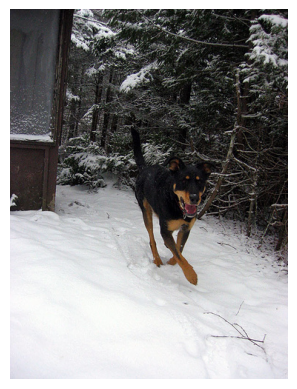

In [ ]:
def get_cap(model,img_feature,tok,max_len):
    in_text = 'startseq'
    for i in range(max_len):
        seq = tok.texts_to_sequences([in_text])[0]
        seq = sequence.pad_sequences([seq], maxlen=max_len,padding='post')
        #rint(img_feature.shape, seq.shape)
        
        y_pred = model.predict([img_feature,seq],verbose = 0)
        res_index = np.argmax(y_pred)
        new_word = idx_to_word[res_index]
        if new_word is None or new_word == 'endseq':
            break
        in_text = in_text + " " + new_word
    final = in_text.split()
    final = final[1:]
    final = ' '.join(final)
    return final

predict_cap = get_cap(model,feature_map['445655284_c29e6d7323.jpg'],tok,max_len)
actual_cap = caption_map['445655284_c29e6d7323.jpg']
print(f'Predict: {predict_cap}')

print(f'Actual: {actual_cap}')
image_path = os.path.join(image_folder, '445655284_c29e6d7323.jpg')

# Load the image
img = Image.open(image_path)

# Plot the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [19]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
actuals = []
preds = []
for id in tqdm(range(len(test_names)), desc="Processing Captions", unit="image"):
    name = test_names[id]
    actual = caption_map[name]
    feat = feature_map[name]
    pred = get_cap(model,feat,tok,max_len)
    actual = [cap.split() for cap in actual]
    pred= pred.split()
    actuals.append(actual)
    preds.append(pred)




In [20]:
bleu4_score = corpus_bleu(actuals, preds, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BLEU-4 Score: {bleu4_score:.4f}")

# BLEU-3 (weights for unigrams, bigrams, trigrams)
bleu3_score = corpus_bleu(actuals, preds, weights=(1/3, 1/3, 1/3, 0.0))
print(f"BLEU-3 Score: {bleu3_score:.4f}")

# BLEU-2 (weights for unigrams and bigrams)
bleu2_score = corpus_bleu(actuals, preds, weights=(0.5, 0.5, 0.0, 0.0))
print(f"BLEU-2 Score: {bleu2_score:.4f}")

# BLEU-1 (only unigrams)
bleu1_score = corpus_bleu(actuals, preds, weights=(1.0, 0.0, 0.0, 0.0))
print(f"BLEU-1 Score: {bleu1_score:.4f}")
